# Tutorial 1: ESG Report Analysis

**By Tobias Schimanski and based on my paper: "Bridiging the Gap in ESG Measurement: Using NLP to Quantify Environmental, Social, and Governance Communication"**

This notebook serves as a basis for applying AI Natural Language Processing tools to corporate sustainability reports. It is particularily tailored for newcomers to the field with limited or no prior experience. In this tutorial, you can only press play and will be fine.

If you are already advanced, you might just [want to read the paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514) and or go directly to the [models on HuggingFace](https://huggingface.co/ESGBERT).

**In this tutorial, we learn to analyse a annual report towards ESG risks and opportunities.**

## Import libraries

We start by importing some standard libraries as well as the "transformers" one. This will help us to use the tools.

In [3]:
%pip install transformers
%pip install tika
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install pytorch torchvision torchaudio
%pip install pytorch-nightly
%pip install spacy
#%micromamba install -c conda-forge tika
#%micromamba install -c conda-forge transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/41/ntzmfcsx5ms7vbngfv__6z540000gr/T/pip-install-ti4gl7vd/pytorch_2d7eef35dce44087b698e3b94ba5d6fc/setup.py", line 15, in <module>
          rai

In [4]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline # for using the models

import spacy # for sentence extraction
import tika
tika.initVM()
from tika import parser # for the report extraction


/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0D991121-1B29-38E8-B953-7A27DA9FCC9B> /Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/andrew.mueller/y/envs/m

## Step 1: Get a feeling for the models

We are going to use models of the [ESG BERT project](https://huggingface.co/ESGBERT). In this tutorial, we don't use GPUs which would speed up the process enourmously.

In [5]:
### Load the models (takes ca. 1 min)
# Environmental model.
name = "ESGBERT/EnvironmentalBERT-environmental" # path to download from HuggingFace
# In simple words, the tokenizer prepares the text for the model and the model classifies the text-
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)
# The pipeline combines tokenizer and model to one process.
pipe_env = pipeline("text-classification", model=model, tokenizer=tokenizer, device='mps:0')

# Also load the social and governance model.
# Social model.
name = "ESGBERT/SocialBERT-social"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)
pipe_soc = pipeline("text-classification", model=model, tokenizer=tokenizer, device='mps:0')

# Governance model.
name = "ESGBERT/GovernanceBERT-governance"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)
pipe_gov = pipeline("text-classification", model=model, tokenizer=tokenizer, device='mps:0')

Now, we downloaded models, tokenizer and create the pipeline. This means, we're already ready to go with the classification.

In [6]:
# You can input single sentences or arrays of sentences into the pipeline,
sentences_test = ["Besides financial considerations, we also consider harms to the biodiversity and broader ecosystem impacts.",
                  "Scope 1 emissions are reported here on a like-for-like basis against the 2013 baseline and exclude emissions from additional vehicles used during repairs.",
                  "Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning."]
test = pipe_env(sentences_test)
print(test)

[{'label': 'environmental', 'score': 0.994878888130188}, {'label': 'environmental', 'score': 0.9979760050773621}, {'label': 'none', 'score': 0.997612714767456}]


In [7]:
# Only output the label of the first sentence.
print(test[0]["label"]) # label of first element

environmental


You can observe an array of lists as output. The first value gives you the label which could be "environmental" or "none". Furthermore, the 'score' gives you an indication of the confidence of the model in its decision. Play around yourself with the other models and produce example outputs.

In [8]:
# Try it yourself. Insert a sentence.
sentences_test_2 = ["A"]
test = pipe_soc(sentences_test_2)
print(test)

[{'label': 'none', 'score': 0.9920572638511658}]


## Step 2: Extract texts from PDFs

Since this tutorial aims to classify the texts in a complete report, we now download an annual report and split it into single sentences.

In [9]:
# We use the AUDI annual report to analyse in this example.
#path = "https://www.audi.com/content/dam/gbp2/downloads/report/annual-reports/2022/en/audi-report-2022.pdf"
path = "/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/AHH_2023.pdf"
# The from_file() function of tika helps us to load the content of the document. (take ca. 30 sec)
report = parser.from_file(path)

In [10]:
# Have a look at the raw content extracted from the PDF.
print(report["content"])
















































SUSTAINABILITY REPORT



A B O U T O U R 
C O M PA N Y

P L A N E T

A B O U T T H I S 
R E P O R T 

A D D R E S S I N G C L I M AT E 
C H A N G E

A L E T T E R F R O M  
O U R C E O

E N V I R O N M E N TA L 
P E R F O R M A N C E D ATA

O U R S U S TA I N A B I L I T Y 
R O A D M A P

C O M M U N I T Y

P E O P L E E C O N O M I C D E V E LO P M E N T 
A N D I N V E S T M E N T

O U R C U LT U R E R E S P O N S I B L E 
B U S I N E S S

D I V E R S I T Y,  E Q U I T Y,  & 
I N C L U S I O N 

01 19

02 22

04 25

06 26

10 27

11 32

14

TABLE OF CONTENTS

A R M A D A  H O F F L E R  



Who We Are and What We Do 
Armada Hoffler (NYSE:AHH) is a vertically integrated, 
self-managed real estate investment trust with over four 
decades of experience developing, building, acquiring, 
and managing high-quality multifamily, office, and retail 
properties located primarily in the Mid-Atlantic and 
Southeastern United States. The Company also 

Now, we want to bring this content on sentence-level to classify it.

In [13]:
# For this, we use the nlp() function from spacy. (takes 20 secs)
nlp = spacy.load('en_core_web_sm')
about_doc = nlp(report["content"])

This allows us to have every text sequence of the report. We can look at the results. This may look a look a bit complicated, but we just transfer the output to a list of text sequences.

In [14]:
# We transfer the sequences ("about_doc.sents") to a list of raw strings.
sequences = list(map(str, about_doc.sents))
# Look at the first 10 text sequences.
sequences[:10]

['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSUSTAINABILITY REPORT\n\n\n\nA B',
 'O',
 'U T O U R \nC',
 'O M PA N Y\n\nP L A N E T\n\nA B O U T T H I S \nR E P',
 'O R T \n\n',
 'A D D R E S S',
 'I N G C L I M AT E \nC H',
 'A N G E\n\nA L E T T E R F R O M  \n',
 'O U R C',
 'E O\n\nE N V']

Looking at the output, it becomes apparent that we have many sequences that are actually no sentences, e.g. headlines. Thus, in this prototype, we use a row of naive filters to improve the output quality.

In [15]:
# "\n" signals a new line. We remove this so that the output looks better.
sentences = [x.replace("\n", "") for x in sequences]

# Remove all empty text, i.e. if the value is "", i.e are empty.
sentences = [x for x in sentences if x != ""]

# A sentence should start with upper case.
sentences = [x for x in sentences if x[0].isupper()]

sentences[:10]

['SUSTAINABILITY REPORTA B',
 'O',
 'U T O U R C',
 'O M PA N YP L A N E TA B O U T T H I S R E P',
 'O R T ',
 'A D D R E S S',
 'I N G C L I M AT E C H',
 'A N G EA L E T T E R F R O M  ',
 'O U R C',
 'E OE N V']

Much more sophisticated filters are possible but also beyond this tutorial.

## Step 3: Classify the whole report

Now, we want to classify the texts. In this demo, we will only classify a subset of the texts towards their environmental label because we are not yet using GPUs (see next tutorials) which will speed up the process immensely. This reduces the time for classification from minutes to seconds. [Full classification now takes around 5 minutes.]

In [16]:
# Classify subset of sentences.
# The padding and trunctuation parameters help us with classifying texts of different length.
sub_sentences = sentences[:100] # takes around 20 seconds
env = pipe_env(sub_sentences, padding=True, truncation=True)

# You might only want the labels.
env_labels = [x["label"] for x in env]

In [17]:
# Let's look at the results. We use a dataframe for this purpose.
data_env = pd.DataFrame({"sentence": sub_sentences, "environmental": env_labels})
# Which sentences are labeled as environmental?
data_env[data_env["environmental"] == "environmental"]
# Click the first blue symbol that looks like a calculator in the top right of the dataframe to have a closer look.
# Click the first blue symbol in the top right of the dataframe to have a closer look.

,sentence,environmental
41,Please send comments or questions about this r...,environmental
43,"In preparing this report, we have referenced r...",environmental
50,O C C,environmental
53,O C C,environmental
66,I T Y R E P O R TWelcome to Armada Hoffler’s ...,environmental
67,"In all that we do, we strive to conduct our bu...",environmental
68,"In this report, we review our operations that ...",environmental
76,Protecting Our PlanetArmada Hoffler remained m...,environmental
77,We took additional steps to further gather and...,environmental
80,"Additionally, we continue to remain committed ...",environmental


               sentence
environmental          
environmental        13
none                 87


<Axes: xlabel='environmental'>

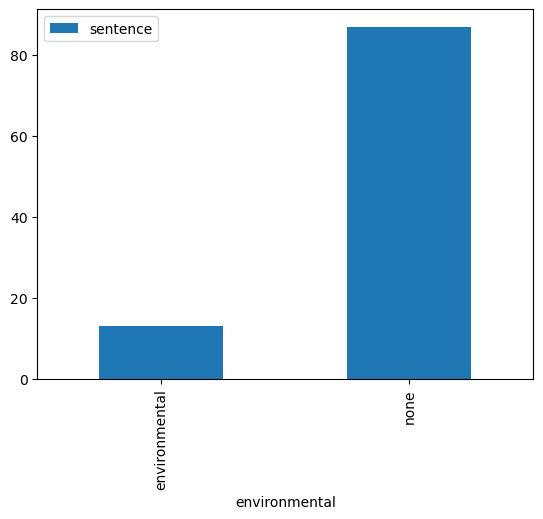

In [18]:
# It could also be interesting to look at the proporation of environmental sentences.
print(data_env.groupby("environmental").count())
data_env.groupby("environmental").count().plot(kind="bar")

This procedure is easily scalable to whole reports or a large number of reports.

## Step 4: Use advanced language patterns

Besides the sole environmental classification, the real value may lie in advanced language patterns. One question of interest might be if the company perceives climate as a risk, neutral or as an opportunity. We borrow models from a related project to identify this: ClimateBERT.

In [20]:
# To load the model, we use the exact same steps as above.
model_name = "climatebert/distilroberta-base-climate-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, max_len=512)
pipe_sent = pipeline("text-classification", model=model, tokenizer=tokenizer, device='mps:0')

In [21]:
# Use the model on the dataset.
sentiment = pipe_sent(sub_sentences, padding=True, truncation=True)
# Add the sentiment to the DataFrame.
data_env["sentiment"] = [x["label"] for x in sentiment]

In [22]:
# Again, have a look at the outcome.
data_env[data_env["environmental"] == "environmental"]
# Click the first blue symbol that looks like a calculator in the top right of the dataframe to have a closer look.
# Audi seems to display a enthusiastic, pironeering spirit towards sustainability. This positive attitude is reflected as "opportunity".

,sentence,environmental,sentiment
41,Please send comments or questions about this r...,environmental,neutral
43,"In preparing this report, we have referenced r...",environmental,neutral
50,O C C,environmental,neutral
53,O C C,environmental,neutral
66,I T Y R E P O R TWelcome to Armada Hoffler’s ...,environmental,neutral
67,"In all that we do, we strive to conduct our bu...",environmental,opportunity
68,"In this report, we review our operations that ...",environmental,neutral
76,Protecting Our PlanetArmada Hoffler remained m...,environmental,neutral
77,We took additional steps to further gather and...,environmental,neutral
80,"Additionally, we continue to remain committed ...",environmental,opportunity


sentiment
neutral        11
opportunity     2
Name: environmental, dtype: int64


<Axes: xlabel='sentiment'>

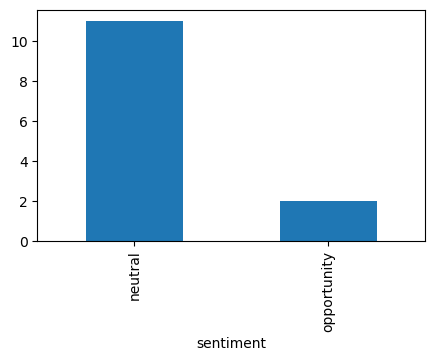

In [23]:
# Let's plot the distribution again.
print(data_env[data_env["environmental"] == "environmental"].groupby("sentiment").count()["environmental"])
data_env[data_env["environmental"] == "environmental"].groupby("sentiment").count()["environmental"].plot(kind = "bar", figsize=(5, 3))

With that, we close today's tutorial. I hope, you found this helpful. I will update this file once the new tutorial on GPUs and large-scale analysis is out. Until then, feel free to read the [paper on the ESG BERTs](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514) or follow [me on LinkedIn](https://www.linkedin.com/in/tobias-schimanski-964077182/) to not miss out on new developments.